# Setup

In [ ]:
!pip install lightgbm
!pip install scikit_optimize
!pip install catboost

     |████████████████████████████████| 100 kB 7.3 MB/s 
     |████████████████████████████████| 76.1 MB 99 kB/s 


In [ ]:
#@markdown Setup
#@markdown - Packages needed.
import os, re, csv, json
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from skopt import BayesSearchCV
from catboost import CatBoostRegressor
import statsmodels.api as sm

from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@markdown Mounting Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@markdown Get Diamond & Gas Turbine Datasets.
diamond_data = pd.read_csv("/content/drive/Shareddrives/ece219/project 4/diamonds.csv")
# diamond_data

gt2011 = pd.read_csv("/content/drive/Shareddrives/ece219/project 4/gt_2011.csv")
gt2012 = pd.read_csv("/content/drive/Shareddrives/ece219/project 4/gt_2012.csv")
gt2013 = pd.read_csv("/content/drive/Shareddrives/ece219/project 4/gt_2013.csv")
gt2014 = pd.read_csv("/content/drive/Shareddrives/ece219/project 4/gt_2014.csv")
gt2015 = pd.read_csv("/content/drive/Shareddrives/ece219/project 4/gt_2015.csv")
gt2011["year"] = [2011] * len(gt2011)
gt2012["year"] = [2012] * len(gt2012)
gt2013["year"] = [2013] * len(gt2013)
gt2014["year"] = [2014] * len(gt2014)
gt2015["year"] = [2015] * len(gt2015)
gt_data = pd.concat([gt2011, gt2012, gt2013, gt2014, gt2015])
#@markdown - Drop CO
gt_data = gt_data.drop('CO',axis = 1)
# gt_data

In [ ]:
gt_data

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX,year
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,81.952,2011
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,82.377,2011
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,83.776,2011
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,82.505,2011
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,82.028,2011
...,...,...,...,...,...,...,...,...,...,...,...
7379,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,89.172,2015
7380,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,88.849,2015
7381,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,96.147,2015
7382,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,64.738,2015


# Required Steps

In [ ]:
#@markdown Handling Categorical Features
#@markdown - Encoding dicts.
cut_encoding = {
  'Fair' : 1, 
  'Good' : 2, 
  'Ideal' : 3, 
  'Premium' : 4, 
  'Very Good' : 5
}

color_encoding = {
  'D' : 7,
  'E' : 6, 
  'F' : 5,
  'G' : 4, 
  'H' : 3, 
  'I' : 2, 
  'J' : 1
}

clarity_encoding = {
  'I1' : 1, 
  'SI2' : 2,
  'SI1' : 3, 
  'VS2' : 4, 
  'VS1' : 5, 
  'VVS2' : 6,
  'VVS1' : 7, 
  'IF' : 8 
}

#@markdown - Encoding helper function: takes feature & encoding dictionary.
def encode_feature(df, feat, encoding_dict):
  feats = df[feat]
  encoded_feats = [encoding_dict[f] for f in feats]
  df[feat] = encoded_feats

#@markdown - Encode `cut`, `color` and `clarity`.
encode_feature(diamond_data, 'cut', cut_encoding)
encode_feature(diamond_data, 'color', color_encoding)
encode_feature(diamond_data, 'clarity', clarity_encoding)

In [ ]:
diamond_data = diamond_data.drop('Unnamed: 0',axis = 1)
diamond_data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,3,6,2,61.5,55.0,330,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,327,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,328,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,337,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,338,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,3,7,3,60.8,57.0,2758,5.75,5.76,3.50
53936,0.72,2,7,3,63.1,55.0,2759,5.69,5.75,3.61
53937,0.70,5,7,3,62.8,60.0,2760,5.66,5.68,3.56
53938,0.86,4,3,2,61.0,58.0,2757,6.15,6.12,3.74


In [ ]:
#@markdown 1. Standardization two datasets. 
diamond_standard = pd.DataFrame(preprocessing.scale(diamond_data),columns = diamond_data.columns)

gt_scale = gt_data.copy().drop('year',axis = 1)
gt_standard = pd.DataFrame(preprocessing.scale(gt_scale),columns = gt_scale.columns)
gt_standard['year'] = np.asanyarray(gt_data['year'])

# Exploring Data

In [ ]:
#@markdown 2. Plot a heatmap of the Pearson correlation matrix of the dataset columns.
diamond_corr = diamond_standard.corr()
gt_corr = gt_standard.corr()

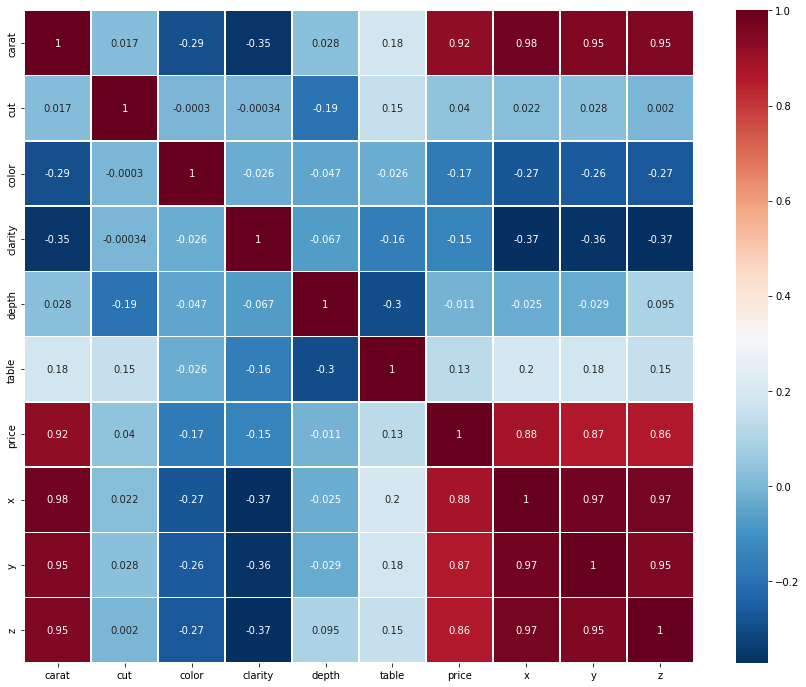

In [ ]:
#@markdown - diamond heatmap
plt.figure(figsize=(15,12))
sb.heatmap(diamond_corr,
            xticklabels=diamond_corr.columns,
            yticklabels=diamond_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

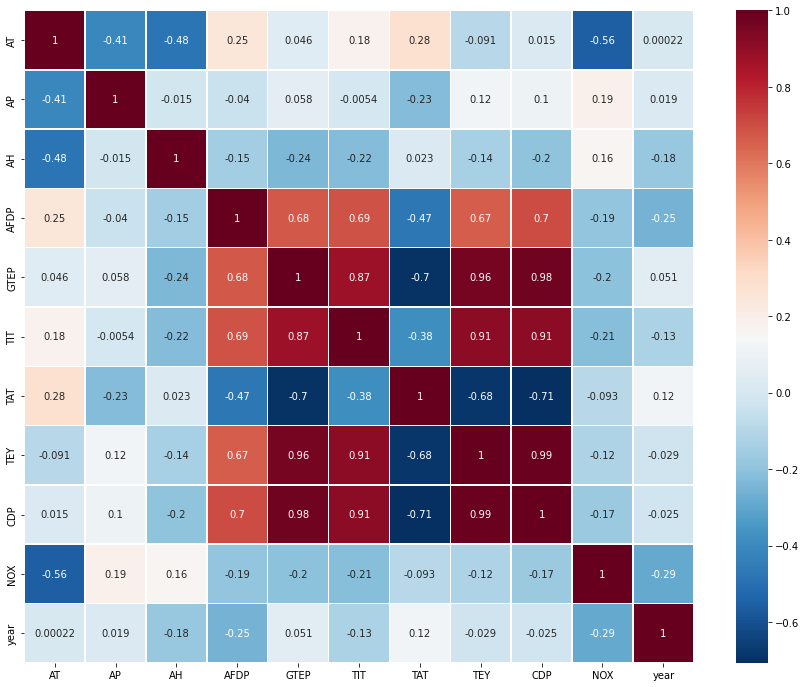

In [ ]:
#@markdown - gas turbine heatmap
plt.figure(figsize=(15,12))
sb.heatmap(gt_corr,
            xticklabels=gt_corr.columns,
            yticklabels=gt_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [ ]:
#@markdown 3. Plot the histogram of numerical features.
#@markdown - diamond
xs_diamond = diamond_standard.drop(['cut','color','clarity','price'],axis =1)
# We don't standardize target var
ys_diamond = diamond_data.iloc[:, -4]

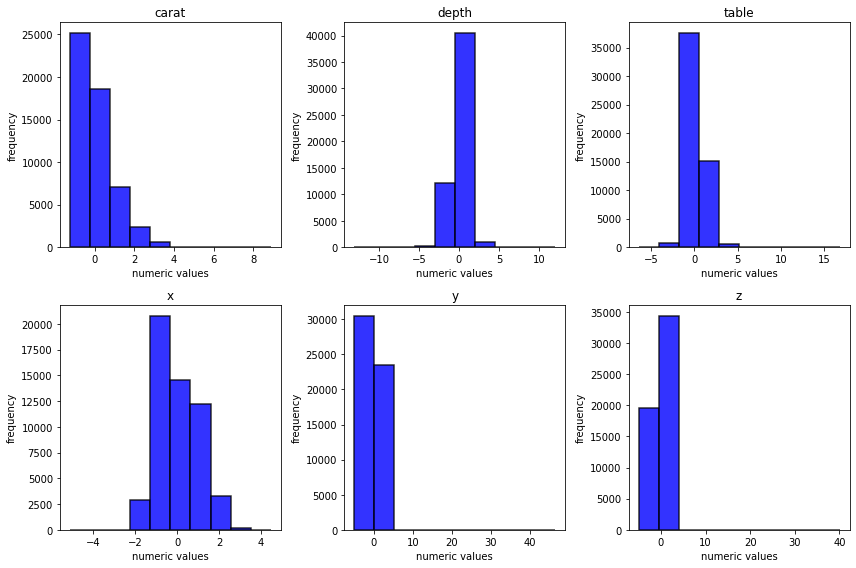

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i in range(2):
  for j in range(3):
    index = i * 3 + j
    axs[i, j].hist(xs_diamond.iloc[:,index], edgecolor='k', facecolor='b', linewidth=1.5, alpha=0.8)
    axs[i, j].set_title(xs_diamond.columns[index])
    axs[i, j].set(xlabel="numeric values", ylabel="frequency")
fig.tight_layout()

In [ ]:
#@markdown - gas turbine
xs_gt = gt_standard.drop(['NOX','year'],axis =1)
ys_gt = gt_data.iloc[:, -2]
xs_gt.columns

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP'], dtype='object')

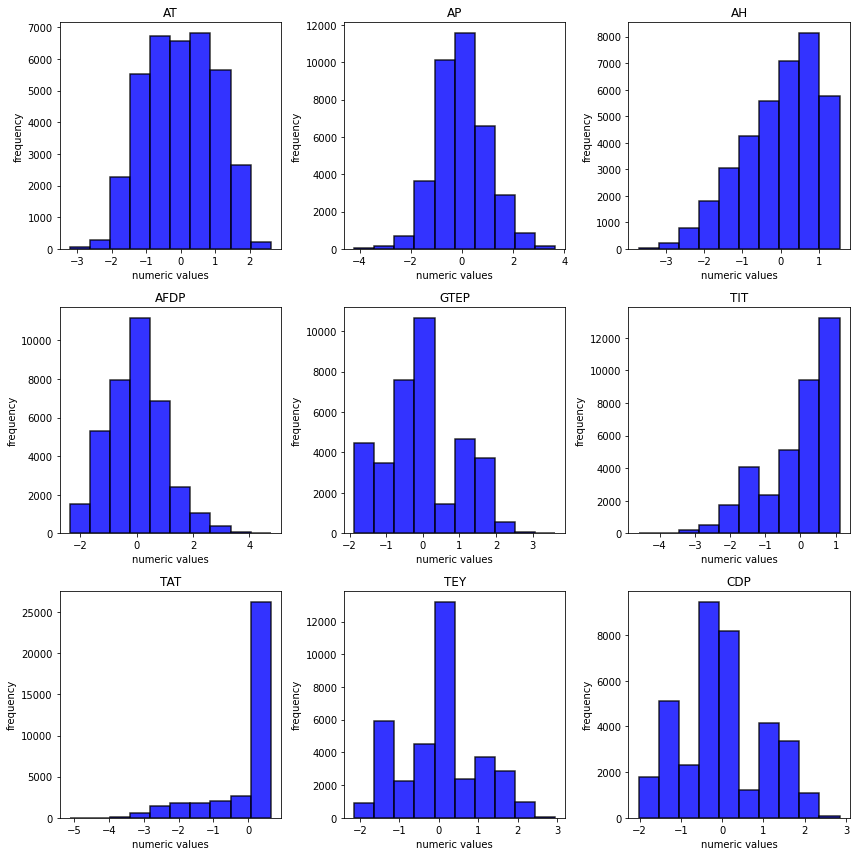

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
  for j in range(3):
    index = i * 3 + j
    axs[i, j].hist(xs_gt.iloc[:,index], edgecolor='k', facecolor='b', linewidth=1.5, alpha=0.8)
    axs[i, j].set_title(xs_gt.columns[index])
    axs[i, j].set(xlabel="numeric values", ylabel="frequency")
fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


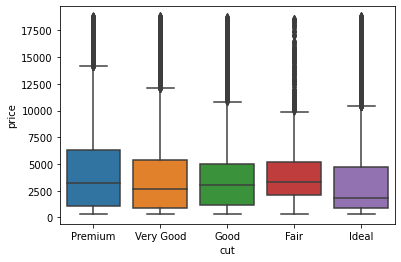

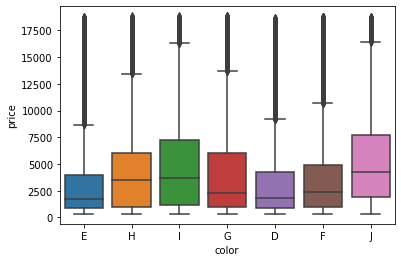

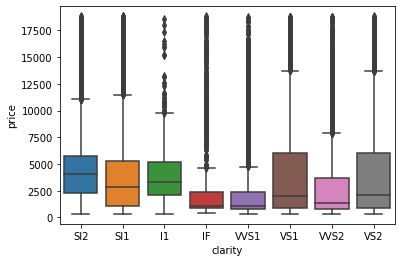

In [ ]:
#@markdown 4. Construct and inspect the box plot of categorical features vs target variable.
#@markdown - diamond
diamond_data_cate = pd.read_csv("/content/drive/Shareddrives/ece219/project 4/diamonds.csv")
sb.boxplot(diamond_data_cate['cut'], ys_diamond, order=list(set(diamond_data_cate['cut'])))
plt.figure()
sb.boxplot(diamond_data_cate['color'], ys_diamond, order=list(set(diamond_data_cate['color'])))
plt.figure()
sb.boxplot(diamond_data_cate['clarity'], ys_diamond, order=list(set(diamond_data_cate['clarity'])))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


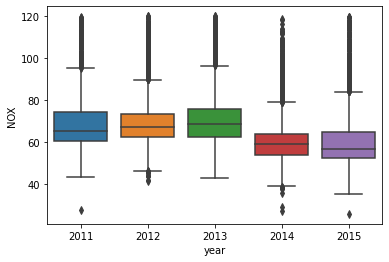

<Figure size 432x288 with 0 Axes>

In [ ]:
#@markdown - gas turbine
sb.boxplot(gt_data['year'], ys_gt, order=list(set(gt_data['year'])))
plt.figure()
plt.show()

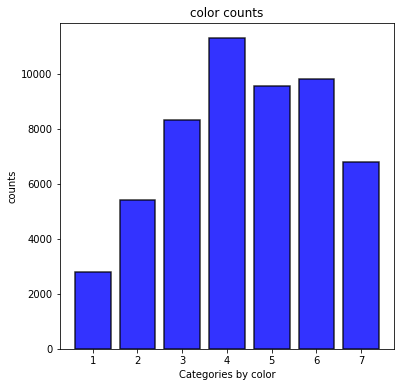

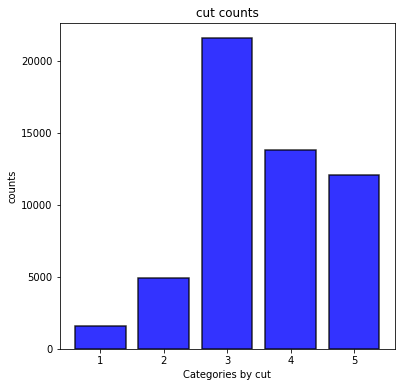

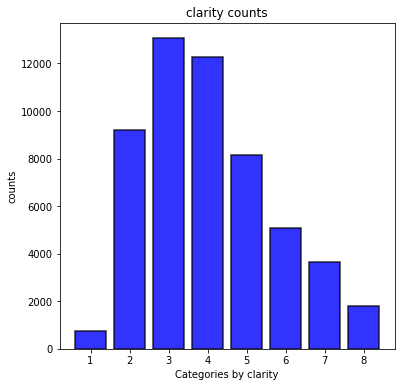

In [ ]:
#@markdown 5. For the Diamonds dataset, plot the counts by color, cut and clarity
def countplot(feature, category):
  fig,ax = plt.subplots(figsize=(6,6))
  count_list=[]
  for i in range(1,category+1):
    count = np.sum(diamond_data[feature]==i)
    count_list.append(count)
  ax.bar(list(range(category)),count_list,edgecolor='k', facecolor='b', linewidth=1.5, alpha=0.8)
  ax.set_xticks(list(range(category)))
  ax.set_xticklabels(list(range(1,category+1)))
  plt.xlabel('Categories by '+ feature)
  plt.ylabel('counts')
  plt.title(feature + " counts")
  plt.show()
#@markdown -  color
countplot('color',7)
#@markdown - cut
countplot('cut',5)
#@markdown - clarity
countplot('clarity',8)

<Figure size 432x288 with 0 Axes>

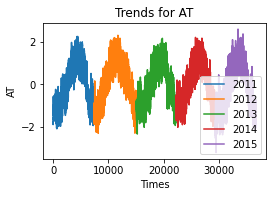

<Figure size 432x288 with 0 Axes>

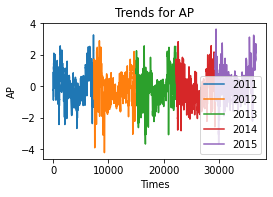

<Figure size 432x288 with 0 Axes>

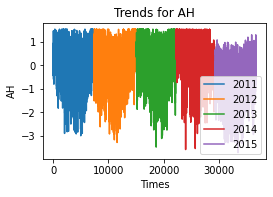

<Figure size 432x288 with 0 Axes>

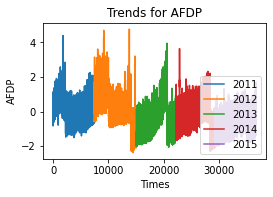

<Figure size 432x288 with 0 Axes>

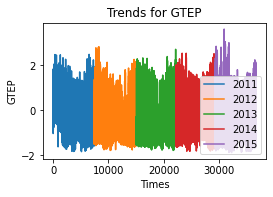

<Figure size 432x288 with 0 Axes>

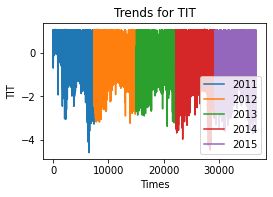

<Figure size 432x288 with 0 Axes>

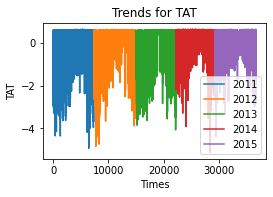

<Figure size 432x288 with 0 Axes>

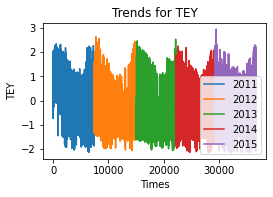

<Figure size 432x288 with 0 Axes>

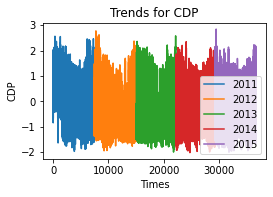

In [ ]:
#@markdown 6. For the Gas Emission dataset, plot the yearly trends for each feature and compare them.
def yearlyTrend(dataset,feature,year):
  plt.plot(dataset.loc[dataset['year'] == year,feature],label = str(year))

year_list = [2011,2012,2013,2014,2015]
feature_list = list(gt_standard.columns.drop(['year','NOX']))
for feature in feature_list:
  plt.gcf().clear()
  plt.subplots(figsize=(4,2.5))
  
  for year in year_list:
    plt.plot(gt_standard.loc[gt_standard['year'] == year,feature],label = str(year))
  plt.title("Trends for "+ str(feature))
  plt.xlabel("Times")
  plt.ylabel(str(feature))
  plt.legend(loc='lower right')
  plt.show()
   

In [ ]:
diamond_data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,3,6,2,61.5,55.0,330,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,327,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,328,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,337,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,338,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,3,7,3,60.8,57.0,2758,5.75,5.76,3.50
53936,0.72,2,7,3,63.1,55.0,2759,5.69,5.75,3.61
53937,0.70,5,7,3,62.8,60.0,2760,5.66,5.68,3.56
53938,0.86,4,3,2,61.0,58.0,2757,6.15,6.12,3.74


In [ ]:
#@markdown 7. Select most important feature
# xs_diamond = diamond_standard.drop(['cut','color','clarity','price'],axis =1)
# xs_gt = gt_standard.drop(['NOX','year'],axis =1)
xs_diamond = diamond_data.drop(['cut','color','clarity','price'],axis =1)
xs_gt = gt_data.drop(['NOX','year'],axis =1)

def topN_important_features(xs, ys, N):
  MutualInfo = mutual_info_regression(xs,ys)
  Fscore = f_regression(xs, ys)
  
  top5_MI = np.argsort(MutualInfo)[::-1][:N]
  top5_FS = np.argsort(Fscore[0])[::-1][:N]

  xs_top5_MI = xs.iloc[:, top5_MI]
  xs_top5_FS = xs.iloc[:, top5_FS]

  return xs_top5_MI, xs_top5_FS

N = 5
diamond_top5_MI, diamond_top5_FS = topN_important_features(xs_diamond, ys_diamond, N)
gt_top5_MI, gt_top5_FS = topN_important_features(xs_gt, ys_gt, N)

print("Top5 selected features for diamond dataset by f_regression:")
print(diamond_top5_FS.columns)

print("Top5 selected features for diamond dataset by mutual_info_regression:")
print(diamond_top5_MI.columns)

print("Top5 selected features for gas dataset by f_regression:")
print(gt_top5_FS.columns)

print("Top5 selected features for gas dataset by mutual_info_regression:")
print(gt_top5_MI.columns)


Top5 selected features for diamond dataset by f_regression:
Index(['carat', 'x', 'y', 'z', 'table'], dtype='object')
Top5 selected features for diamond dataset by mutual_info_regression:
Index(['carat', 'y', 'x', 'z', 'table'], dtype='object')
Top5 selected features for gas dataset by f_regression:
Index(['AT', 'TIT', 'GTEP', 'AP', 'AFDP'], dtype='object')
Top5 selected features for gas dataset by mutual_info_regression:
Index(['TIT', 'TEY', 'AT', 'GTEP', 'CDP'], dtype='object')


In [ ]:
diamond_top5_FS

,carat,x,y,z,table
0,0.23,3.95,3.98,2.43,55.0
1,0.21,3.89,3.84,2.31,61.0
2,0.23,4.05,4.07,2.31,65.0
3,0.29,4.20,4.23,2.63,58.0
4,0.31,4.34,4.35,2.75,58.0
...,...,...,...,...,...
53935,0.72,5.75,5.76,3.50,57.0
53936,0.72,5.69,5.75,3.61,55.0
53937,0.70,5.66,5.68,3.56,60.0
53938,0.86,6.15,6.12,3.74,58.0


# Linear Regression

In [ ]:
#@markdown 8-11. Linear Regression
#@markdown - diamond

#ordinary MSE
lr_pip_std = Pipeline([
    ('standardize', preprocessing.StandardScaler()),
    ('model', LinearRegression())
])

lr_pip_nstd = Pipeline([
    ('model', LinearRegression())
])

In [ ]:
lr_train_diamond = []
lr_test_diamond = []

diamond_xs = [diamond_top5_MI, diamond_top5_FS]

for x in diamond_xs:
    cv_diamond = cross_validate(lr_pip_std, x, ys_diamond, scoring='neg_root_mean_squared_error', 
                                return_train_score=True, cv=10)
    lr_train_diamond.append(np.mean(cv_diamond['train_score']))
    lr_test_diamond.append(np.mean(cv_diamond['test_score']))
    cv_diamond = cross_validate(lr_pip_nstd, x, ys_diamond, scoring='neg_root_mean_squared_error', 
                                return_train_score=True, cv=10)
    lr_train_diamond.append(np.mean(cv_diamond['train_score']))
    lr_test_diamond.append(np.mean(cv_diamond['test_score']))

In [ ]:
lr_res_diamond = pd.DataFrame(data={'mean_test_score': lr_test_diamond, 'mean_train_score': lr_train_diamond,
                                'param_model': 'LinearRegression()', 'param_model__alpha': 'N/A', 
                                'Standardize': [True, False, True, False], 
                                'Feature Selection': ['Mutual Information', 'Mutual Information', 'F Scores', 'F Scores']})

In [ ]:
#Ridge,Lasso
param_grid_ridge_lasso = {
    'model': [Ridge(random_state = 42,max_iter=10000), Lasso(random_state = 42,max_iter=10000)],
    'model__alpha': [10.0**x for x in np.arange(-3,4)]
}

In [ ]:
grid_MI_std_diamond = GridSearchCV(lr_pip_std, param_grid=param_grid_ridge_lasso, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(diamond_top5_MI, ys_diamond)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [ ]:
grid_FS_std_diamond = GridSearchCV(lr_pip_std, param_grid=param_grid_ridge_lasso, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(diamond_top5_FS, ys_diamond)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [ ]:
grid_MI_nstd_diamond = GridSearchCV(lr_pip_nstd, param_grid=param_grid_ridge_lasso, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(diamond_top5_MI, ys_diamond)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [ ]:
grid_FS_nstd_diamond = GridSearchCV(lr_pip_nstd, param_grid=param_grid_ridge_lasso, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(diamond_top5_FS, ys_diamond)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [ ]:
lr_res_MI_std_diamond = pd.DataFrame(grid_MI_std_diamond.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha']]
lr_res_MI_std_diamond['Standardize'] = True
lr_res_MI_std_diamond['Feature Selection'] = 'Mutual Information'

lr_res_FS_std_diamond = pd.DataFrame(grid_FS_std_diamond.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha']]
lr_res_FS_std_diamond['Standardize'] = True
lr_res_FS_std_diamond['Feature Selection'] = 'F Scores'

lr_res_MI_nstd_diamond = pd.DataFrame(grid_MI_nstd_diamond.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha']]
lr_res_MI_nstd_diamond['Standardize'] = False
lr_res_MI_nstd_diamond['Feature Selection'] = 'Mutual Information'

lr_res_FS_nstd_diamond = pd.DataFrame(grid_FS_nstd_diamond.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha']]
lr_res_FS_nstd_diamond['Standardize'] = False
lr_res_FS_nstd_diamond['Feature Selection'] = 'F Scores'

lr_diamond = pd.concat([lr_res_diamond, lr_res_MI_std_diamond, lr_res_FS_std_diamond, lr_res_MI_nstd_diamond, lr_res_FS_nstd_diamond])
lr_diamond = lr_diamond.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
lr_diamond.head()


,mean_test_score,mean_train_score,param_model,param_model__alpha,Standardize,Feature Selection
0,-1408.599008,-1504.205849,LinearRegression(),N/A,True,F Scores
1,-1408.599008,-1504.205849,LinearRegression(),N/A,False,F Scores
2,-1408.599008,-1504.205849,LinearRegression(),N/A,True,Mutual Information
3,-1408.599008,-1504.205849,LinearRegression(),N/A,False,Mutual Information
4,-1408.599082,-1504.205849,"Ridge(alpha=0.001, max_iter=10000, random_stat...",0.001,True,F Scores


In [ ]:
diamond_fit = sm.OLS(ys_diamond, sm.add_constant(xs_diamond)).fit()
diamond_fit.pvalues.sort_values(ascending=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const     0.000000e+00
carat     0.000000e+00
depth    1.493370e-294
table    1.648931e-239
x        3.392377e-203
y         9.353084e-03
z         3.470755e-01
dtype: float64

In [ ]:
#@markdown - gas turbine

#ordinary MSE
lr_pip_std = Pipeline([
    ('standardize', preprocessing.StandardScaler()),
    ('model', LinearRegression())
])

lr_pip_nstd = Pipeline([
    ('model', LinearRegression())
])

In [ ]:
lr_train_gt = []
lr_test_gt = []

gt_xs = [gt_top5_MI, gt_top5_FS]

for x in gt_xs:
    cv_gt = cross_validate(lr_pip_std, x, ys_gt, scoring='neg_root_mean_squared_error', 
                                return_train_score=True, cv=10)
    lr_train_gt.append(np.mean(cv_gt['train_score']))
    lr_test_gt.append(np.mean(cv_gt['test_score']))
    cv_gt = cross_validate(lr_pip_nstd, x, ys_gt, scoring='neg_root_mean_squared_error', 
                                return_train_score=True, cv=10)
    lr_train_gt.append(np.mean(cv_gt['train_score']))
    lr_test_gt.append(np.mean(cv_gt['test_score']))

In [ ]:
lr_res_gt= pd.DataFrame(data={'mean_test_score': lr_test_gt, 'mean_train_score': lr_train_gt,
                                'param_model': 'LinearRegression()', 'param_model__alpha': 'N/A', 
                                'Standardize': [True, False, True, False], 
                                'Feature Selection': ['Mutual Information', 'Mutual Information', 'F Scores', 'F Scores']})

In [ ]:
#Ridge,Lasso
param_grid_ridge_lasso = {
    'model': [Ridge(random_state = 42,max_iter=10000), Lasso(random_state = 42,max_iter=10000)],
    'model__alpha': [10.0**x for x in np.arange(-3,4)]
}

In [ ]:
grid_MI_std_gt = GridSearchCV(lr_pip_std, param_grid=param_grid_ridge_lasso, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(gt_top5_MI, ys_gt)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [ ]:
grid_FS_std_gt = GridSearchCV(lr_pip_std, param_grid=param_grid_ridge_lasso, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(gt_top5_FS, ys_gt)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [ ]:
grid_MI_nstd_gt = GridSearchCV(lr_pip_nstd, param_grid=param_grid_ridge_lasso, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(gt_top5_MI, ys_gt)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [ ]:
grid_FS_nstd_gt = GridSearchCV(lr_pip_nstd, param_grid=param_grid_ridge_lasso, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(gt_top5_FS, ys_gt)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [ ]:
lr_res_MI_std_gt = pd.DataFrame(grid_MI_std_gt.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha']]
lr_res_MI_std_gt['Standardize'] = True
lr_res_MI_std_gt['Feature Selection'] = 'Mutual Information'

lr_res_FS_std_gt = pd.DataFrame(grid_FS_std_gt.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha']]
lr_res_FS_std_gt['Standardize'] = True
lr_res_FS_std_gt['Feature Selection'] = 'F Scores'

lr_res_MI_nstd_gt = pd.DataFrame(grid_MI_nstd_gt.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha']]
lr_res_MI_nstd_gt['Standardize'] = False
lr_res_MI_nstd_gt['Feature Selection'] = 'Mutual Information'

lr_res_FS_nstd_gt = pd.DataFrame(grid_FS_nstd_gt.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha']]
lr_res_FS_nstd_gt['Standardize'] = False
lr_res_FS_nstd_gt['Feature Selection'] = 'F Scores'

lr_gt = pd.concat([lr_res_gt, lr_res_MI_std_gt, lr_res_FS_std_gt, lr_res_MI_nstd_gt, lr_res_FS_nstd_gt])
lr_gt = lr_gt.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
lr_gt.head()


,mean_test_score,mean_train_score,param_model,param_model__alpha,Standardize,Feature Selection
0,-9.450098,-9.149821,"Lasso(max_iter=10000, random_state=42)",0.01,True,Mutual Information
1,-9.453797,-9.144270,"Lasso(max_iter=10000, random_state=42)",0.001,True,Mutual Information
2,-9.454315,-9.146621,"Ridge(alpha=0.001, max_iter=10000, random_stat...",10.0,True,Mutual Information
3,-9.454963,-9.144242,"Ridge(alpha=0.001, max_iter=10000, random_stat...",1.0,True,Mutual Information
4,-9.455322,-9.144213,"Ridge(alpha=0.001, max_iter=10000, random_stat...",0.1,True,Mutual Information


In [ ]:
gt_fit = sm.OLS(ys_gt, sm.add_constant(xs_gt)).fit()
gt_fit.pvalues.sort_values(ascending=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


AT        0.000000e+00
AH        0.000000e+00
TIT       0.000000e+00
TAT       0.000000e+00
TEY       0.000000e+00
AP       1.254925e-186
AFDP      5.737233e-16
const     4.445363e-06
CDP       4.355106e-03
GTEP      4.225138e-02
dtype: float64

# Polynomial Regression

In [ ]:
#@markdown 12. Polynomial Regression: Most Salient Features
#@markdown - diamond

poly_pip_diamond = Pipeline([
    ('poly_transform', PolynomialFeatures()),
    ('standardize', StandardScaler()),
    ('model', Ridge(alpha=0.001, random_state=42, max_iter=10000))
])
param_grid_poly = {
    'poly_transform__degree': np.arange(1,11,1)
}

In [ ]:
poly_cv_diamond  = GridSearchCV(
    poly_pip_diamond, 
    param_grid=param_grid_poly, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(diamond_top5_FS, ys_diamond)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
poly_res_diamond = pd.DataFrame(poly_cv_diamond.cv_results_)[['mean_test_score', 'mean_train_score', 'param_poly_transform__degree']]
poly_res_diamond = poly_res_diamond.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
poly_res_diamond

,mean_test_score,mean_train_score,param_poly_transform__degree
0,-1.408599e+03,-1504.205849,1
1,-2.488461e+03,-1396.210901,2
2,-2.983248e+04,-1365.223638,3
3,-1.602447e+05,-1350.618237,4
4,-2.128503e+06,-1347.164063,5
5,-2.461246e+07,-1344.947087,6
6,-1.916215e+08,-1342.838194,7
7,-1.049253e+09,-1341.201128,8
8,-4.192811e+09,-1339.641431,9
9,-1.317617e+10,-1338.153415,10


In [ ]:
#@markdown - gas turbine
poly_pip_gt = Pipeline([
    ('poly_transform', PolynomialFeatures()),
    ('standardize', StandardScaler()),
    ('model', Lasso(alpha=0.01, random_state=42, max_iter=2000))
])
param_grid_poly = {
    'poly_transform__degree': np.arange(5,11,1)
}

In [ ]:
poly_cv_gt  = GridSearchCV(
    poly_pip_gt, 
    param_grid=param_grid_poly, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(gt_top5_MI, ys_gt)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.475e+05, tolerance: 5.010e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
poly_res_gt = pd.DataFrame(poly_cv_gt.cv_results_)[['mean_test_score', 'mean_train_score', 'param_poly_transform__degree']]
poly_res_gt = poly_res_gt.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
poly_res_gt

,mean_test_score,mean_train_score,param_poly_transform__degree
0,-7.733145,-7.224939,9
1,-7.739469,-7.196248,10
2,-7.764628,-7.260575,8
3,-7.821199,-7.311683,7
4,-7.899467,-7.387677,6
5,-8.013455,-7.499803,5


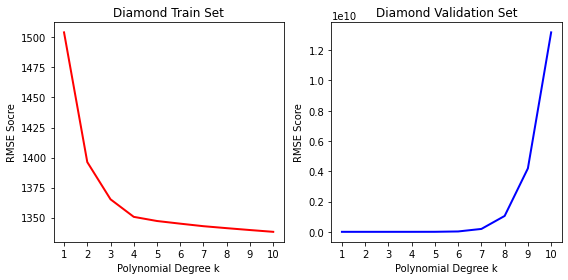

In [ ]:
#@markdown 13. Polynomial Regression: Best Polynomial Degree
#@markdown - diamond
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(poly_res_diamond['param_poly_transform__degree'], -poly_res_diamond['mean_train_score'], linewidth=2, color='r')
plt.xticks(np.arange(1,11,1))
plt.xlabel('Polynomial Degree k')
plt.ylabel('RMSE Socre')
plt.title('Diamond Train Set')

plt.subplot(1,2,2)
plt.plot(poly_res_diamond['param_poly_transform__degree'], -poly_res_diamond['mean_test_score'], linewidth=2, color='b')
plt.xticks(np.arange(1,11,1))
plt.xlabel('Polynomial Degree k')
plt.ylabel('RMSE Score')
plt.title('Diamond Validation Set')

plt.tight_layout()
plt.show()

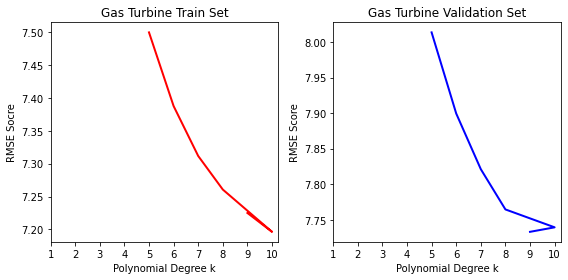

In [ ]:
#@markdown - gas turbine
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(poly_res_gt['param_poly_transform__degree'], -poly_res_gt['mean_train_score'], linewidth=2, color='r')
plt.xticks(np.arange(1,11,1))
plt.xlabel('Polynomial Degree k')
plt.ylabel('RMSE Socre')
plt.title('Gas Turbine Train Set')

plt.subplot(1,2,2)
plt.plot(poly_res_gt['param_poly_transform__degree'], -poly_res_gt['mean_test_score'], linewidth=2, color='b')
plt.xticks(np.arange(1,11,1))
plt.xlabel('Polynomial Degree k')
plt.ylabel('RMSE Score')
plt.title('Gas Turbine Validation Set')

plt.tight_layout()
plt.show()

In [ ]:
#@markdown 14. Polynomial Regression: New Features for diamond dataset
xs_std_diamond = diamond_standard.drop(['cut','color','clarity','price'],axis =1)
Fscore_diamond = f_regression(xs_std_diamond, ys_diamond)

top5_FS_diamond = np.argsort(Fscore_diamond[0])[::-1][:5]

xs_top5_FS_diamond = xs_std_diamond.iloc[:, top5_FS_diamond]



In [ ]:
new_feature = np.prod(xs_diamond[['carat', 'x']], axis=1)
new_feature = preprocessing.scale(new_feature)

In [ ]:
xs_diamond_new_feature = np.concatenate((xs_top5_FS_diamond, new_feature.reshape(-1,1)), axis=1)
cv_new_feature = cross_validate(Ridge(alpha=0.001, random_state=42, max_iter=1000), 
                                   xs_diamond_new_feature, ys_diamond, scoring='neg_root_mean_squared_error', cv=10)
rmse_new_feature = np.mean(-cv_new_feature['test_score'])
rmse_new_feature

1394.657443903877

# Neural Network **warning: Colab Pro only**

In [ ]:
#@markdown 15 - 18. Neural Network

#@markdown Diamond: 
#@markdown - Hyperparameter **alpha**: 0.1, 0.01, 0.005.
#@markdown - Hyperparameter **activation**: 'relu', 'logistic', 'tanh'.
#@markdown - Hyperparameter **hidden_layer_sizes**: 100,150,200.
alphas = [0.1, 0.01, 0.005]
activations = ['relu', 'logistic', 'tanh']
hidden_layers = [100,150,200]
hidden_layers_d1 = []
hidden_layers_d2 = []
hidden_layers_d3 = []  
for hl in hidden_layers:
  comb2 = tuple([hl] * 2)
  comb3 = tuple([hl] * 3)
  hidden_layers_d1.append(hl)
  hidden_layers_d2.append(comb2)
  hidden_layers_d3.append(comb3)

In [ ]:
nn_pip_diamond = Pipeline([
    ('standardize', StandardScaler()),
    ('model', MLPRegressor(random_state=42, max_iter=2000))
])
param_nn_d1 = {
    'model__alpha': alphas,
    'model__activation': activations,
    'model__hidden_layer_sizes': hidden_layers_d1
}


In [ ]:
nn_cv_diamond_d1 = GridSearchCV(
    nn_pip_diamond, 
    param_grid=param_nn_d1, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(diamond_top5_FS, ys_diamond)

In [ ]:
nn_res_d1_diamond = pd.DataFrame(nn_cv_diamond_d1.cv_results_)[[
    'mean_test_score', 
    'mean_train_score', 
    'param_model__alpha',
    'param_model__activation',
    'param_model__hidden_layer_sizes'
]]


In [ ]:
# We run the result locally in our PC, results can be found in our report
nn_res_diamond = nn_res_d1_diamond.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
nn_res_diamond

In [ ]:
#@markdown Gas: 
#@markdown - Hyperparameter **alpha**: 0.1, 0.01, 0.005.
#@markdown - Hyperparameter **activation**: 'relu', 'logistic', 'tanh'.
#@markdown - Hyperparameter **hidden_layer_sizes**: 100,150,200.
alphas = [0.1, 0.01, 0.005]
activations = ['relu', 'logistic', 'tanh']
hidden_layers = [100,150,200]
hidden_layers_d1 = []
hidden_layers_d2 = []
hidden_layers_d3 = []  
for hl in hidden_layers:
  comb2 = tuple([hl] * 2)
  comb3 = tuple([hl] * 3)
  hidden_layers_d1.append(hl)
  hidden_layers_d2.append(comb2)
  hidden_layers_d3.append(comb3)

In [ ]:
nn_pip_gt = Pipeline([
    ('standardize', StandardScaler()),
    ('model', MLPRegressor(random_state=42, max_iter=2000))
])
param_nn_d2 = {
    'model__alpha': alphas,
    'model__activation': activations,
    'model__hidden_layer_sizes': hidden_layers_d2
}


In [ ]:
nn_cv_gt_d2 = GridSearchCV(
    nn_pip_gt, 
    param_grid=param_nn_d2, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(gt_top5_MI, ys_gt)

In [ ]:

nn_res_d2_gt = pd.DataFrame(nn_cv_gt_d2.cv_results_)[[
    'mean_test_score', 
    'mean_train_score', 
    'param_model__alpha',
    'param_model__activation',
    'param_model__hidden_layer_sizes'
]]


In [ ]:
nn_res_d2_gt

,mean_test_score,mean_train_score,param_model__alpha,param_model__activation,param_model__hidden_layer_sizes
0,-7.509562,-6.047456,0.1,relu,"(100, 100)"
1,-7.469834,-6.030676,0.1,relu,"(150, 150)"
2,-7.737920,-6.043765,0.1,relu,"(200, 200)"
3,-7.839761,-6.062116,0.01,relu,"(100, 100)"
4,-7.474214,-5.974080,0.01,relu,"(150, 150)"
5,-7.627646,-6.018200,0.01,relu,"(200, 200)"
6,-7.607163,-6.018576,0.005,relu,"(100, 100)"
7,-7.460844,-5.989425,0.005,relu,"(150, 150)"
8,-7.790313,-6.079037,0.005,relu,"(200, 200)"
9,-7.400975,-6.151433,0.1,logistic,"(100, 100)"


# Random Forest

In [ ]:
#@markdown 19 - 21. Random Forest
num_features = np.arange(0.1,1.1,0.1)
num_trees = np.arange(10,210,10)
max_depths = np.arange(1,31,1)


In [ ]:
#@markdown Diamond
rf_pip_diamond = Pipeline([
    ('standardize', StandardScaler()),
    ('model', RandomForestRegressor())
])
param_rf_n_est = {
    'model__n_estimators': num_trees,
}
param_rf_max_depth = {
    'model__max_depth': max_depths,
}
param_rf_max_features = {
    'model__max_features': num_features
}

In [ ]:
rf_cv_diamond_n_est = GridSearchCV(
    rf_pip_diamond, 
    param_grid=param_rf_n_est, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(diamond_top5_FS, ys_diamond)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
rf_cv_diamond_max_depth = GridSearchCV(
    rf_pip_diamond, 
    param_grid=param_rf_max_depth, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(diamond_top5_FS, ys_diamond)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
rf_cv_diamond_max_features = GridSearchCV(
    rf_pip_diamond, 
    param_grid=param_rf_max_features, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(diamond_top5_FS, ys_diamond)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
rf_res_diamond_n_est = pd.DataFrame(rf_cv_diamond_n_est.cv_results_)[[
    'mean_test_score', 
    'mean_train_score', 
    'param_model__n_estimators'
]]

rf_res_diamond_n_est = rf_res_diamond_n_est.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
rf_res_diamond_n_est

,mean_test_score,mean_train_score,param_model__n_estimators
0,-1475.893421,-520.295100,190
1,-1476.618646,-520.127955,200
2,-1476.817459,-522.221505,130
3,-1476.847772,-520.563772,170
4,-1476.935283,-524.755174,100
5,-1477.001514,-523.493186,120
6,-1477.004211,-520.614566,180
7,-1477.018578,-520.949339,160
8,-1477.321461,-522.117500,140
9,-1478.100238,-521.521195,150


In [ ]:
rf_res_diamond_max_depth = pd.DataFrame(rf_cv_diamond_max_depth.cv_results_)[[
    'mean_test_score', 
    'mean_train_score', 
    'param_model__max_depth'

]]

rf_res_diamond_max_depth = rf_res_diamond_max_depth.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
rf_res_diamond_max_depth

,mean_test_score,mean_train_score,param_model__max_depth
0,-1432.114225,-1247.060799,9
1,-1433.003364,-1215.059738,10
2,-1433.648161,-1176.977619,11
3,-1434.202847,-1274.266487,8
4,-1435.532886,-1134.415418,12
5,-1436.881460,-1085.722704,13
6,-1438.625244,-1297.428737,7
7,-1442.664914,-1032.769188,14
8,-1444.432479,-974.762671,15
9,-1446.886553,-1318.084857,6


In [ ]:
rf_res_diamond_max_features = pd.DataFrame(rf_cv_diamond_max_features.cv_results_)[[
    'mean_test_score', 
    'mean_train_score', 
    'param_model__max_features'
]]

rf_res_diamond_max_features = rf_res_diamond_max_features.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
rf_res_diamond_max_features

,mean_test_score,mean_train_score,param_model__max_features
0,-1452.755434,-515.503876,0.3
1,-1453.624578,-515.662162,0.1
2,-1454.459408,-515.879388,0.2
3,-1459.836219,-518.626148,0.5
4,-1460.855967,-518.428692,0.4
5,-1468.198860,-521.320605,0.7
6,-1470.175969,-520.454986,0.6
7,-1473.700590,-523.038468,0.9
8,-1473.866624,-523.155849,0.8
9,-1480.429990,-525.082720,1.0


In [ ]:
rf_viz_diamond = RandomForestRegressor(n_estimators=190, max_features=0.3, max_depth=4, random_state=42, oob_score=True)
rf_viz_diamond.fit(diamond_top5_FS, ys_diamond)

RandomForestRegressor(max_depth=4, max_features=0.3, n_estimators=190,
                      oob_score=True, random_state=42)

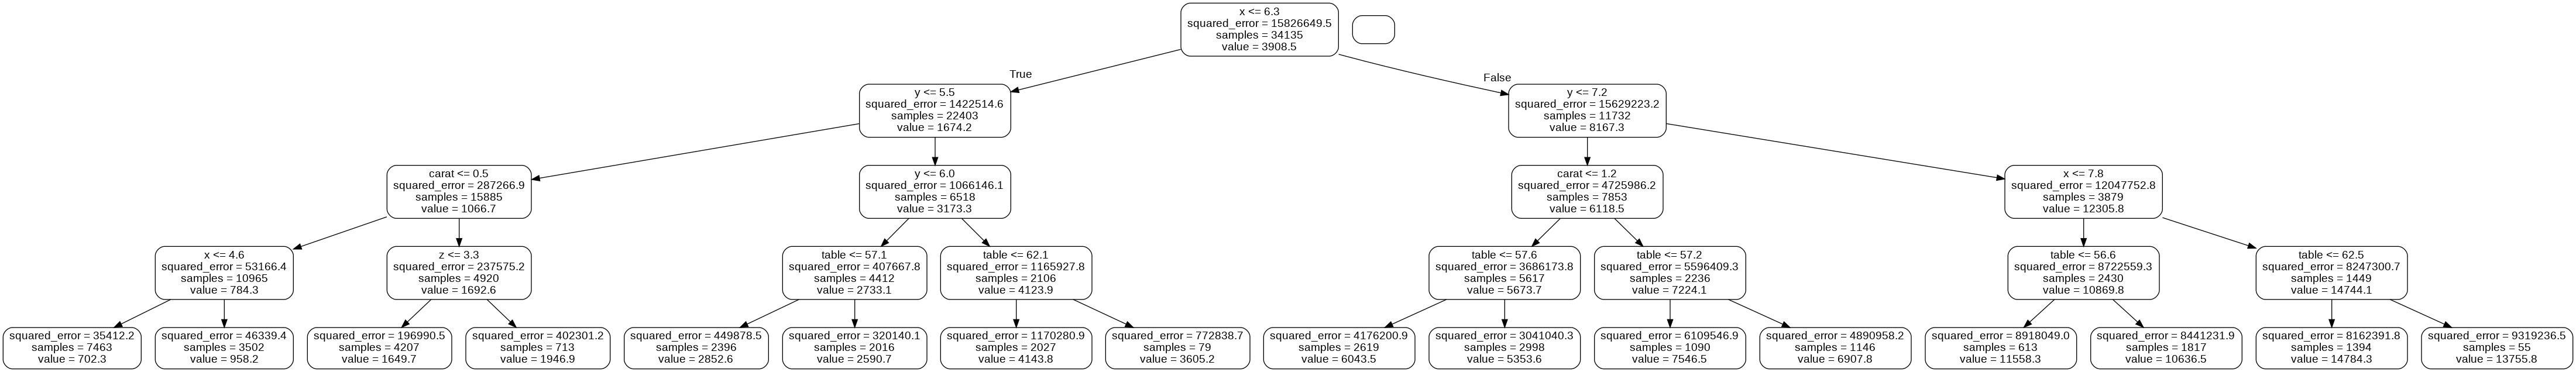

In [ ]:
rf_diamond = rf_viz_diamond.estimators_[1]
export_graphviz(rf_diamond, out_file = 'rf_diamond.dot', feature_names = diamond_top5_FS.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('rf_diamond.dot')
Image(graph.create_png())

In [ ]:
#@markdown - gas turbin
rf_pip_gt = Pipeline([
    ('standardize', StandardScaler()),
    ('model', RandomForestRegressor())
])

In [ ]:
rf_cv_gt_n_est = GridSearchCV(
    rf_pip_gt, 
    param_grid=param_rf_n_est, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(gt_top5_MI, ys_gt)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
rf_cv_gt_max_depth = GridSearchCV(
    rf_pip_gt, 
    param_grid=param_rf_max_depth, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(gt_top5_MI, ys_gt)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
rf_cv_gt_max_features = GridSearchCV(
    rf_pip_gt, 
    param_grid=param_rf_max_features, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
).fit(gt_top5_MI, ys_gt)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
rf_res_gt_n_est = pd.DataFrame(rf_cv_gt_n_est.cv_results_)[[
    'mean_test_score', 
    'mean_train_score', 
    'param_model__n_estimators'
]]

rf_res_gt_n_est = rf_res_gt_n_est.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
rf_res_gt_n_est

,mean_test_score,mean_train_score,param_model__n_estimators
0,-7.620168,-2.168295,200
1,-7.620639,-2.193384,100
2,-7.623862,-2.172810,170
3,-7.624399,-2.183039,130
4,-7.624579,-2.173634,160
5,-7.627191,-2.176529,140
6,-7.631562,-2.168281,190
7,-7.633433,-2.175126,150
8,-7.633921,-2.171593,180
9,-7.637480,-2.203572,80


In [ ]:
rf_res_gt_max_depth = pd.DataFrame(rf_cv_gt_max_depth.cv_results_)[[
    'mean_test_score', 
    'mean_train_score', 
    'param_model__max_depth'

]]

rf_res_gt_max_depth = rf_res_gt_max_depth.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
rf_res_gt_max_depth

,mean_test_score,mean_train_score,param_model__max_depth
0,-7.496697,-5.072578,11
1,-7.506729,-4.723843,12
2,-7.516061,-4.379089,13
3,-7.520916,-5.419586,10
4,-7.528310,-5.758460,9
5,-7.529124,-4.047270,14
6,-7.563647,-3.725714,15
7,-7.564116,-3.453639,16
8,-7.566298,-6.091478,8
9,-7.578409,-3.201785,17


In [ ]:
rf_res_gt_max_features = pd.DataFrame(rf_cv_gt_max_features.cv_results_)[[
    'mean_test_score', 
    'mean_train_score', 
    'param_model__max_features'
]]

rf_res_gt_max_features = rf_res_gt_max_features.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
rf_res_gt_max_features

,mean_test_score,mean_train_score,param_model__max_features
0,-7.378146,-2.205668,0.2
1,-7.381496,-2.207027,0.1
2,-7.386176,-2.207446,0.3
3,-7.426436,-2.172261,0.4
4,-7.438703,-2.172723,0.5
5,-7.481258,-2.174597,0.7
6,-7.504523,-2.174859,0.6
7,-7.556498,-2.183932,0.9
8,-7.573901,-2.180890,0.8
9,-7.636391,-2.193490,1.0


In [ ]:
rf_viz_gt = RandomForestRegressor(n_estimators=200, max_features=0.2, max_depth=4, random_state=42, oob_score=True)
rf_viz_gt.fit(gt_top5_MI, ys_gt)

RandomForestRegressor(max_depth=4, max_features=0.2, n_estimators=200,
                      oob_score=True, random_state=42)

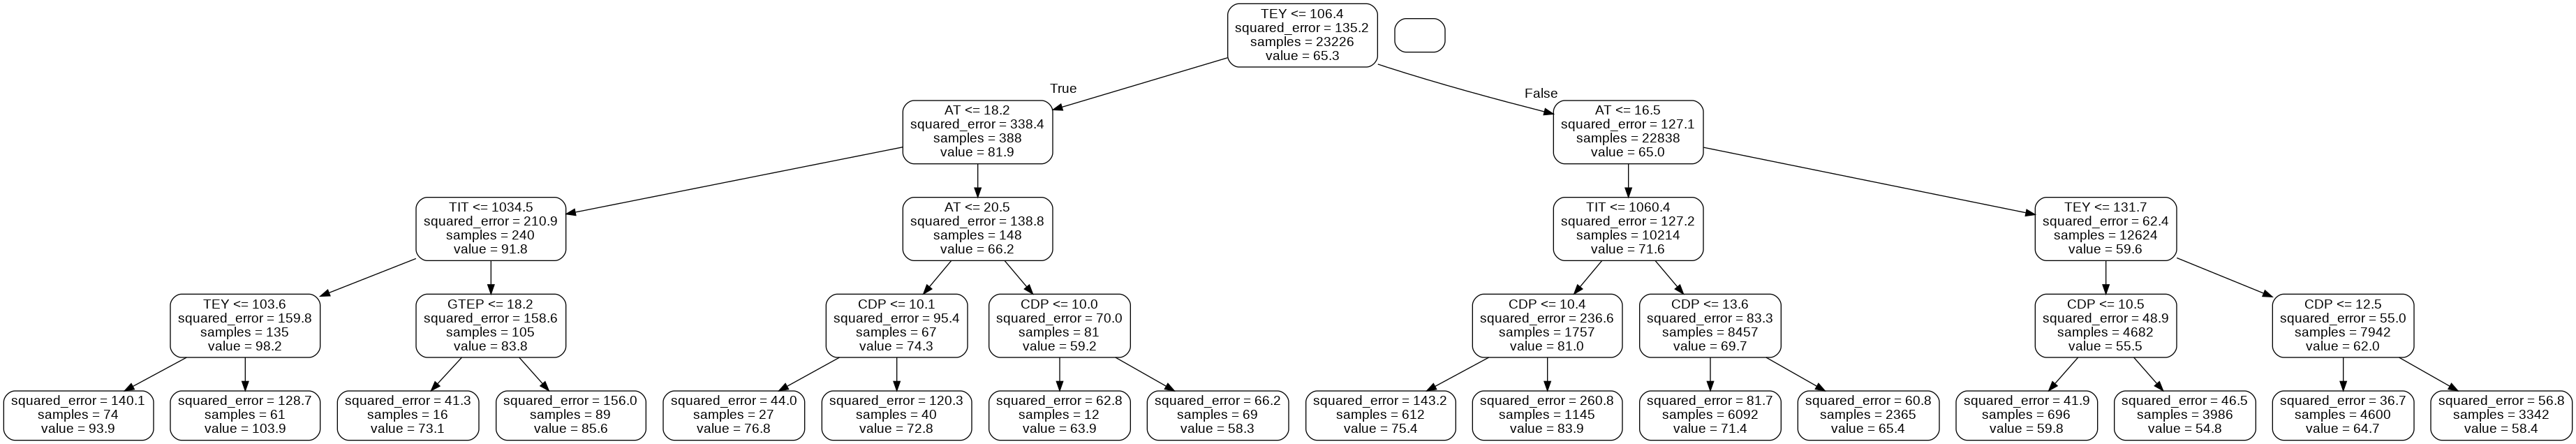

In [ ]:
rf_gt = rf_viz_gt.estimators_[1]
export_graphviz(rf_gt, out_file = 'rf_gt.dot', feature_names = gt_top5_MI.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('rf_gt.dot')
Image(graph.create_png())

#LightGBM

In [ ]:
#@markdown  diamond
lg_diamond = lgb.LGBMRegressor()
lbg_pip_diamond = Pipeline(steps=[
    ('standardize', StandardScaler()),
    ('model', lg_diamond)
])
param_lgb_diamond = {
    'model__max_depth': np.arange(1, 31, 1),
    'model__n_estimators': np.arange(10, 210, 10),
    'model__lambda_l2': np.arange(10,110,10)
}

In [ ]:
lg_cv_diamond = BayesSearchCV(
    lbg_pip_diamond, 
    search_spaces=param_lgb_diamond, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
)
lg_cv_diamond=lg_cv_diamond.fit(diamond_top5_FS, ys_diamond)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [ ]:
lgb_res_diamond = pd.DataFrame(lg_cv_diamond.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model__max_depth','param_model__n_estimators','param_model__lambda_l2']]
lgb_res_diamond = lgb_res_diamond.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True).drop_duplicates(keep='last',inplace=False)
lgb_res_diamond

,mean_test_score,mean_train_score,param_model__max_depth,param_model__n_estimators,param_model__lambda_l2
13,-1420.941270,-1306.286014,26,40,90
14,-1420.941270,-1306.286014,17,40,90
15,-1422.277001,-1302.957209,17,40,60
16,-1423.256684,-1283.001509,27,80,90
17,-1423.473742,-1283.763837,27,80,100
18,-1423.529944,-1286.791443,8,80,100
19,-1423.617947,-1298.374222,15,40,30
20,-1423.691987,-1289.444754,7,60,50
21,-1424.004763,-1326.029984,7,30,70
22,-1424.147308,-1275.585328,17,110,100


# CatBoost

In [ ]:
#@markdown diamond
cb_diamond = CatBoostRegressor()
cb_pip_diamond = Pipeline(steps=[
    ('standardize', StandardScaler()),
    ('model', cb_diamond)
])
param_cb_diamond = {
    'model__max_depth': np.arange(1, 10, 1),
    'model__n_estimators': np.arange(10, 210, 10),
    'model__l2_leaf_reg': np.arange(1,31,1)
}

In [ ]:
cb_cv_diamond = BayesSearchCV(
    cb_pip_diamond, 
    search_spaces=param_cb_diamond, 
    cv=10, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
)
cb_cv_diamond=cb_cv_diamond.fit(diamond_top5_FS, ys_diamond)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
0:	learn: 3887.5352580	total: 69.9ms	remaining: 13.9s
1:	learn: 3788.5595599	total: 81.4ms	remaining: 8.06s
2:	learn: 3692.6665418	total: 91.5ms	remaining: 6.01s
3:	learn: 3599.8930725	total: 101ms	remaining: 4.96s
4:	learn: 3510.3631388	total: 111ms	remaining: 4.33s
5:	learn: 3423.8907090	total: 120ms	remaining: 3.88s
6:	learn: 3340.4860562	total: 130ms	remaining: 3.58s
7:	learn: 3260.0387331	total: 142ms	remaining: 3.41s
8:	learn: 3181.6763019	total: 154ms	remaining: 3.27s
9:	learn: 3106.4746040	total: 165ms	remaining: 3.14s
10:	learn: 3034.1962102	total: 175ms	remaining: 3s
11:	learn: 2964.3272383	total: 185ms	remaining: 2.89s
12:	learn: 2897.3791678	total: 194ms	remaining: 2.79s
13:	learn: 2832.3736143	total: 204ms	remaining: 2.71s
14:	learn: 2769.5999737	total: 213ms	remaining: 2.63s
15:	learn: 2709.1288157	total: 223ms	remaining: 2.56s
16:	learn: 2651.5005985	total: 233ms	remaining: 2.51s
17:	learn: 2596.0761535	total: 

In [ ]:
cb_res_diamond = pd.DataFrame(cb_cv_diamond.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model__max_depth','param_model__n_estimators','param_model__l2_leaf_reg']]
cb_res_diamond = cb_res_diamond.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True).drop_duplicates(keep='last',inplace=False)
cb_res_diamond

,mean_test_score,mean_train_score,param_model__max_depth,param_model__n_estimators,param_model__l2_leaf_reg
8,-1429.539339,-1324.322736,9,200,11
9,-1429.920840,-1325.982611,9,190,11
11,-1430.126213,-1326.324099,9,200,15
12,-1430.653384,-1327.928723,9,190,15
13,-1431.039571,-1328.535176,9,200,20
14,-1431.098808,-1328.930198,9,200,21
15,-1432.444892,-1337.955259,9,140,11
16,-1432.505726,-1332.035234,9,190,27
17,-1433.190102,-1341.623119,9,130,11
18,-1433.384362,-1332.744193,7,190,11


#OOB

In [ ]:
#@markdown 26. OOB
#@markdown - diamond
rf_diamond_opt = RandomForestRegressor(n_estimators=190, max_features=0.3, max_depth=9, random_state=42, oob_score=True)
rf_diamond_opt.fit(diamond_top5_FS, ys_diamond)
                   
print('Best Random Forest Model for Diamond Dataset:')
print('OOB score: %.4f' %(rf_diamond_opt.oob_score_))
print('R^2 score: %.4f' %(rf_diamond_opt.score(diamond_top5_FS, ys_diamond)))

Best Random Forest Model for Diamond Dataset:
OOB score: 0.8847
R^2 score: 0.8927


In [ ]:
#@markdown - gas turbine
rf_gt_opt = RandomForestRegressor(n_estimators=200, max_features=0.2, max_depth=11, random_state=42, oob_score=True)
rf_gt_opt.fit(gt_top5_MI, ys_gt)
                   
print('Best Random Forest Model for Gas Turbine Dataset:')
print('OOB score: %.4f' %(rf_gt_opt.oob_score_))
print('R^2 score: %.4f' %(rf_gt_opt.score(gt_top5_MI, ys_gt)))

Best Random Forest Model for Gas Turbine Dataset:
OOB score: 0.6984
R^2 score: 0.7548


In [ ]:
#@markdown 25. OOB
from sklearn import model_selection
kf = model_selection.KFold(n_splits=10)
from sklearn.metrics import mean_squared_error
RMSE_train = []
RMSE_test = []
for train_index, test_index in kf.split(diamond_top5_FS,ys_diamond):
    X_train= diamond_top5_FS.iloc[train_index]
    y_train= ys_diamond.iloc[train_index]
    X_test= diamond_top5_FS.iloc[test_index]
    y_test= ys_diamond.iloc[test_index]
    reg = RandomForestRegressor(n_estimators=190, max_features=0.3, max_depth=9, random_state=42, oob_score=True)
    reg.fit(X_train, y_train)
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    RMSE_train.append(np.sqrt(mean_squared_error(y_train, pred_train)))
    RMSE_test.append(np.sqrt(mean_squared_error(y_test, pred_test)))

print("Diamond dataset:")
print('RMSE for train data=',np.mean(RMSE_train))
print('RMSE for test data=',np.mean(RMSE_test))


RMSE for train data= 1275.6840014315767
RMSE for test data= 1433.9212681958873


In [ ]:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=10)
from sklearn.metrics import mean_squared_error
RMSE_train = []
RMSE_test = []
for train_index, test_index in kf.split(gt_top5_MI,ys_gt):
    X_train= gt_top5_MI.iloc[train_index]
    y_train= ys_gt.iloc[train_index]
    X_test= gt_top5_MI.iloc[test_index]
    y_test= ys_gt.iloc[test_index]
    reg = rf_gt_opt = RandomForestRegressor(n_estimators=200, max_features=0.2, max_depth=11, random_state=42, oob_score=True)
    reg.fit(X_train, y_train)
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    RMSE_train.append(np.sqrt(mean_squared_error(y_train, pred_train)))
    RMSE_test.append(np.sqrt(mean_squared_error(y_test, pred_test)))

print("Gas dataset:")
print('RMSE for train data=',np.mean(RMSE_train))
print('RMSE for test data=',np.mean(RMSE_test))


Gas dataset:
RMSE for train data= 5.683679914626244
RMSE for test data= 7.415761073155126
